In [14]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import json
import pandas as pd

import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.time_measurement as time_measurement
from lib.ext.baycon.common.DataAnalyzer import *
from lib.ext.baycon.common.Target import Target

<Axes: >

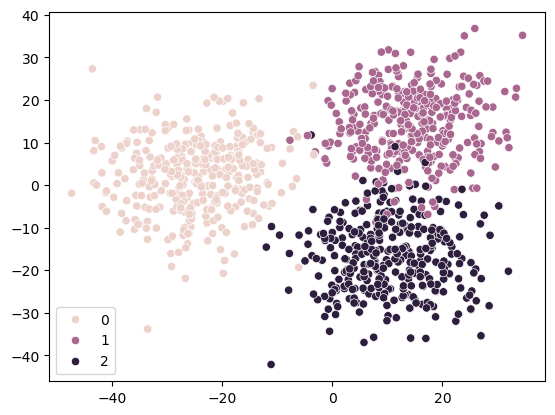

In [15]:
X, y = make_blobs(centers=3, cluster_std=8, n_features=20, n_samples=1000)

pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

In [16]:
model = RandomForestClassifier()
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,label
0,15.360463,10.122535,-9.148383,8.310474,5.130110,-11.058928,-4.561148,8.434352,-1.545685,-8.295648,...,12.008687,-25.146546,13.707796,-8.480300,-0.372565,-6.689510,1.587344,-5.903852,17.964128,1.0
1,0.579031,-14.449437,-5.819680,-9.918289,8.173429,9.298996,-23.539858,-7.721205,4.603626,-13.246367,...,-2.704974,-14.917954,8.061804,1.265959,7.486615,14.587226,7.730238,2.355321,3.030227,0.0
2,-10.552130,11.080154,1.017376,-2.000594,-9.673073,-1.534639,-3.914353,2.947149,3.955063,-6.034590,...,5.974930,-2.221167,-16.488301,-20.902542,7.761480,0.937593,0.669349,-7.063707,-11.455016,2.0
3,-17.421854,16.263476,-3.355340,-14.586081,-3.761093,5.740470,17.077337,-12.287967,-16.298127,17.711782,...,-23.846785,-6.900609,-6.283821,-2.744107,-0.195078,13.777710,-7.740509,3.420553,8.897988,2.0
4,-2.006170,-5.126226,-0.044934,-4.619133,-12.129882,9.033192,-13.738849,-15.199589,-9.847841,-1.330211,...,-5.913474,16.787015,21.368441,-6.428755,10.597572,5.818852,-16.151628,3.893854,-17.913389,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-15.362094,-9.850437,6.343603,-5.276077,-3.599499,-2.505860,7.085685,-0.107869,-18.329444,5.898262,...,5.162966,-9.746819,-11.650822,-0.724692,-3.462855,1.632239,7.923694,-20.026878,-12.759307,2.0
996,-2.031623,8.177243,13.427977,6.330725,-1.130357,-0.232679,-0.741100,11.822026,-5.085788,2.287731,...,-5.641308,4.922191,13.590261,4.793785,7.695488,8.975751,-5.020677,-11.879547,-1.978488,1.0
997,-1.371574,-11.562732,-16.408475,-11.889934,-14.574518,23.432102,-9.342990,-15.944439,-9.061231,2.662218,...,3.537850,16.121413,5.046467,14.326784,-0.510630,9.691557,-16.876377,1.026862,-13.913015,0.0
998,-3.773303,6.261202,4.408159,9.573229,-20.757868,-5.722213,-6.689168,5.410297,-15.806077,2.670159,...,6.491918,-4.131306,-2.776617,-5.671199,-5.193575,2.142274,10.858963,-15.604093,13.239268,1.0


<Axes: >

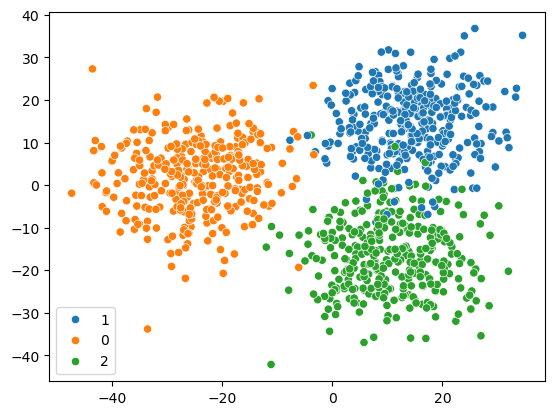

In [17]:
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=pred)

In [18]:
def execute(df, model, target, initial_instance_index, categorical_features=[], actionable_features=[]):
    y = df[[target.target_feature()]].values.ravel()
    X = df.drop([target.target_feature()], axis=1).values
    feature_names = df.columns[df.columns != target.target_feature()]

    run = 0
    data_analyzer = DataAnalyzer(X, y, feature_names, target, categorical_features, actionable_features)
    X, y = data_analyzer.data()
    initial_instance = X[initial_instance_index]
    initial_prediction = y[initial_instance_index]
    print("--- Executing... Initial Instance: {} Target: {} Run: {} ---".format(
        initial_instance_index,
        target.target_value_as_string(),
        run
    ))
    counterfactuals, ranker = baycon.run(initial_instance, initial_prediction, target, data_analyzer, model)
    predictions = np.array([])
    try:
        predictions = model.predict(counterfactuals)
    except ValueError:
        pass
    output = {
        "initial_instance": initial_instance.tolist(),
        "initial_prediction": str(initial_prediction),
        "categorical_features": categorical_features,
        "actionable_features": actionable_features,
        "target_type": target.target_type(),
        "target_value": target.target_value(),
        "target_feature": target.target_feature(),
        "total_time": str(time_measurement.total_time),
        "time_to_first_solution": str(time_measurement.time_to_first_solution),
        "time_to_best_solution": str(time_measurement.time_to_best_solution),
        "counterfactuals": counterfactuals.tolist(),
        "predictions": predictions.tolist()
    }

    # output_filename = "{}_{}_{}_{}_{}_{}.json".format("bcg", dataset_name, initial_instance_index,
    #                                                   target.target_value_as_string(), model_name, run)
    # with open(output_filename, 'w') as outfile:
    #     json.dump(output, outfile)
    # print("--- Finished: saved file {}\n".format(output_filename))

    return counterfactuals, predictions, initial_instance, initial_prediction #, data_analyzer, ranker, model


In [23]:
point_idx = 0
point_pred = int(model.predict([X[point_idx]])[0])
print("Point prediction: ", point_pred, type(point_pred))
t = Target(target_type="classification", target_feature="label", target_value=0)

cf, _predictions, _initial_instance, _initial_prediction = execute(df, model, t, point_idx)

Point prediction:  1 <class 'int'>
--- Executing... Initial Instance: 0 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (655) CFs (0)
Re-training surrogate model with data size: 655
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (0) Unique overall (0)
Generated random instances: (3230)
Predicted top: 20 Counterfactuals: 2
Found new best [-18.84723382 -12.2574916   -0.          14.52199135   5.13010958
   3.7762022  -13.90975258   8.43435204   1.08684723  -4.07494833
  -9.25178865  12.00868685 -25.14654588  -8.03998772 -16.99243488
  -0.37256506  -6.6895095   -7.27213189  -1.06187348  -3.62115227], with fitness score 0.2572 (X 0.73483 Y 1.0 F 0.35), oversampling
Known alternatives: 675
Best instance score 0.2572 (X 0.73483 Y 1.0 F 0.35), found on epoch: 1
Re-training surrogate model with data size: 685
--- epoch 2 ----
Generati

<Axes: >

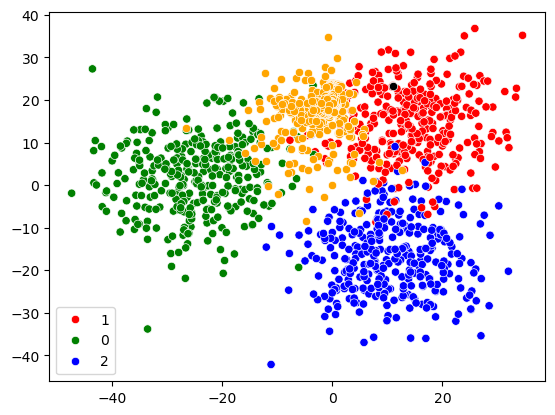

In [24]:
embed_cf = pca.transform(cf)
sns.scatterplot(x=embed_X[:,0], y=embed_X[:,1], hue=pred, palette=['red','green','blue'])
sns.scatterplot(x=embed_cf[:,0], y=embed_cf[:,1], color='orange')
sns.scatterplot(x=embed_X[[0],0], y=embed_X[[0],1], color='black')